In [1]:
import os, sys, pickle
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path = list(set(sys.path))
import matplotlib.pyplot as plt
%matplotlib inline

from common.evaluate import make_vis_env, test_env

from flow.multiagent_envs import MultiWaveAttenuationMergePOEnv
from flow.scenarios import MergeScenario
from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder
from ray.tune import run_experiments

import gym, ray
from ray.rllib.agents.ppo import PPOAgent, DEFAULT_CONFIG
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print

benchmark_name = 'multi_merge'

In [2]:
ray.init(num_cpus=1, include_webui=False, ignore_reinit_error=True)

Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-04-18_18-15-57_222/logs.
Waiting for redis server at 127.0.0.1:36976 to respond...
Waiting for redis server at 127.0.0.1:51459 to respond...
Starting the Plasma object store with 13.355121049 GB memory using /dev/shm.


{'node_ip_address': '169.237.32.118',
 'object_store_addresses': ['/tmp/ray/session_2019-04-18_18-15-57_222/sockets/plasma_store'],
 'raylet_socket_names': ['/tmp/ray/session_2019-04-18_18-15-57_222/sockets/raylet'],
 'redis_address': '169.237.32.118:36976',
 'webui_url': ''}

In [3]:
benchmark = __import__(
    "flow.benchmarks.%s" % benchmark_name, fromlist=["flow_params"])
flow_params = benchmark.flow_params
horizon = flow_params['env'].horizon

def make_env(create_env):
    def _thunk():
        env = create_env()
        return env
    return _thunk

create_env, env_name = make_create_env(params=flow_params, version=0)

In [4]:
# Register as rllib env
register_env(env_name, create_env)

In [5]:
checkpoint = '475'

In [6]:
config_path = '/headless/rl_project/ray_results/multi_merge/PPO_MultiWaveAttenuationMergePOEnv-v0_0_2019-04-17_06-00-52g_2xwa_e/params.pkl'
checkpoint_path = '/headless/rl_project/ray_results/multi_merge/PPO_MultiWaveAttenuationMergePOEnv-v0_0_2019-04-17_06-00-52g_2xwa_e/checkpoint_{}/checkpoint-{}'.format(checkpoint, checkpoint)

In [7]:
with open(config_path, mode='rb') as f:
    config = pickle.load(f)

In [8]:
agent = PPOAgent(config=config, env=env_name)

Created LogSyncer for /headless/ray_results/PPO_MultiWaveAttenuationMergePOEnv-v0_2019-04-18_18-15-59q9dvkij0 -> None
 Starting SUMO on port 39906
2019-04-18 18:16:01,057	INFO policy_evaluator.py:262 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
 Starting SUMO on port 39906
2019-04-18 18:16:04,460	INFO multi_gpu_optimizer.py:74 -- LocalMultiGPUOptimizer devices ['/cpu:0']
/opt/conda/envs/flow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [9]:
agent.restore(checkpoint_path)

In [10]:
# env = make_vis_env(flow_params, MultiWaveAttenuationMergePOEnv, MergeScenario)
env = create_env()

 Starting SUMO on port 57134


In [12]:
# calculate the space-time velocity map
left_length = env.k.scenario.edge_length('left')
car_length = 5.0
scale = 10

state = env.reset()
for i in range(env.env_params.horizon):
    # record the velocity map
    ids = env.k.vehicle.get_ids()
    vel_map_ = np.zeros(int(left_length)*scale)
    for id_ in ids:
        pos_ = np.round(env.k.vehicle.get_position(id_), decimals=1)
        vel_ = env.k.vehicle.get_speed(id_)
        pos_bottom = max(0, int((pos_-car_length/2.0)*scale))
        pos_top = min(int(left_length)*scale, int((pos_+car_length/2.0)*scale))
        vel_map_[pos_bottom:pos_top] = vel_            
        
    # step the simulation
    rl_ids = env.k.vehicle.get_rl_ids()
    actions = {}
    for id_ in rl_ids:
        action = agent.compute_action(state[id_])
        actions.update({id_: action})
    state, r, _, _ = env.step(actions)
    
    if i == 0:
        vel_map_list = vel_map_
    else:
        vel_map_list = np.vstack((vel_map_list, vel_map_))
        
vel_map_list[vel_map_list==0.0] = np.nan

 Starting SUMO on port 57134


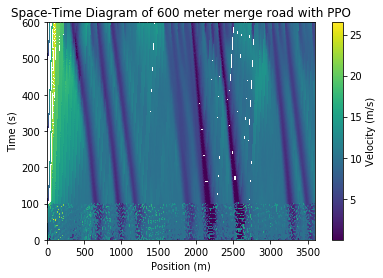

In [13]:
x = np.arange(int(env.env_params.horizon))
y = np.arange(0, int(left_length), step=0.1)
xx, yy = np.meshgrid(x, y)
plt.xlabel('Position (m)')
plt.ylabel('Time (s)')
title = 'Space-Time Diagram of 600 meter merge road with PPO'
savepath = '../result/' + title.replace(' ', '_') + '.png'
plt.title(title)
plt.pcolormesh(xx, yy, vel_map_list.T)
clb = plt.colorbar()
clb.set_label('Velocity (m/s)')
plt.savefig(savepath)